In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cmath
from datetime import datetime
from scipy.optimize import fsolve
# !pip install git+https://github.com/dpk2442/pysmith.git#egg=pysmith

Clonar repo para descargar archivos de materiales medidos:

In [ ]:
!git clone https://github.com/tinchodeluca/ME2-PROY-SONDA.git

fatal: destination path 'ME2-PROY-SONDA' already exists and is not an empty directory.


Funcion para relevar los archivos que se encuentran en la carpeta de recursos ('rsc') y cargarlos en un diccionario, accediendo como "***files['15-11-23'][0]***"

In [ ]:
file_path = './ME2-PROY-SONDA/rsc/'
files = {}

for folder in os.listdir(file_path):
  if os.path.isdir(file_path + '/' + folder ):
    file_names = os.listdir( file_path + '/' + folder + '/' )
    files[folder] = file_names
    #print(file_names)

In [ ]:
# print(files)
# {'15-11-23':
#       ['Dedo.s1p',           #0
# 			'Pla.s1p',             #1
# 			'Acetona.s1p',         #2
# 			'Aire.s1p',            #3
# 			'Agua.s1p',            #4
# 			'Alcohol.s1p',         #5
# 			'Abs_Diluido.s1p'],    #6
# '21-12-23':
#       ['Resina.s1p',         #0
# 			'AcetonaN.s1p',        #1
# 			'ResinaN.s1p',         #2
# 			'AbsN.s1p',            #3
# 			'Acetona.s1p',         #4
# 			'Glicerina.s1p',       #5
# 			'Abs.s1p',             #6
# 			'Agua_destiladaN.s1p', #7
# 			'Corto.s1p',           #8
# 			'GlicerinaN.s1p'],     #9
# '15-08-23':
#      ['Resina.s1p',
# 			'Acetona.s1p',
# 			'Aire.s1p',
# 			'Azucar.s1p',
# 			'Agua_Destilada.s1p',
# 			'Alcohol.s1p']}


In [ ]:
def vna_proc_file(file_path, file_name): #Procesa archivos S1P de VNA cuyas columnas son |Frec |Real{S11} |Imag{S11} |
    if ( file_path[-1] != '/' ):
      file_path += '/'
    file_path += file_name
    header_start  = '#'
    data_start    = '!'
    out_dict = {'Frec' : [],
                # 'Data' : [],
                # 'Index': [],
              }
    frecuencies = np.array([])
    complejos   = np.array([])
    phase       = np.array([])
    try:
        file = open(file_path, "r")
    except:
        print('TODO: No se puede abrir')
        return 404
    file_list = file.readlines()
    # print(file_list)
    file.close()
    for line in file_list[12:]: #De la linea 12 en adelante
        values      = line.strip().split('\t')
        frecuencies = np.append(frecuencies, np.float32(values[0]))
        complejos   = np.append(complejos, convertir_a_rectangular(np.float32(values[1]), np.float32(values[2])))

    # out_dict['Data'   ] = file_list[0:11]
    # out_dict['Index'  ] = file_list[11][1:].split(' ')
    out_dict['Frec'   ] = frecuencies
    out_dict['Complex'] = complejos

    return out_dict

def convertir_a_rectangular(modulo_db, fase_grados):
    modulo = 10 ** (modulo_db / 20)
    fase_radianes = np.radians(fase_grados)
    return modulo * np.exp(1j * fase_radianes)

    # return np.real(numero_complejo), np.imag(numero_complejo)

def S11_to_Y11(frec, S11):
    z0 = 50
    y0 = 1/z0
    Y11 = y0*(( 1 - S11 ) / ( 1 + S11 ))
    return { 'Frec'    : frec,
             'Complex' : Y11,
            }

Patrones del modelo Debye en función de la frecuencia

In [ ]:
def get_debye_model(frecs): #Patron agua destilada
    w     = frecs*2*np.pi
    E_inf = 4.6
    E_s   = 78.3
    tau   = 8.07e-12
    E_c   = E_inf + (E_s-E_inf)/(1-1j*w*tau)
    return E_c

def get_er_pat_alc_etilico(frecs):
    A = 4.505 + ((24.43 - 4.505) / (1 + 1j * frecs / (0.964e9))) - 1j * frecs * 0.056 / 1e9
    return np.real(A), -1j * np.imag(A)

def get_er_pat_alc_isopropilico(frecs):
    # curva del er complejo del isopropilico al 99 segun la curva de deybe
    ER = 3.065 + ((19.30 - 3.551) / (1 + 1j * frecs / (0.443e9))) + ((3.551 - 3.065) / (1 + 1j * frecs / (5.999e9)))
    return ER

Función para submuestrear un archivo de mediciones y hacerlo compatible con otro de menor frecuencia de muestreo

In [ ]:
def SUBsample_S11 (small_dict, big_dict):
  if (len(small_dict['Frec']) < len(big_dict['Frec']) ):
    index = len(big_dict['Frec']) - 1
    while ( index >= 0 ):
        if( big_dict['Frec'][index] not in small_dict['Frec'] ):
            big_dict['Frec']    = np.delete(big_dict['Frec'], index)
            big_dict['Complex'] = np.delete(big_dict['Complex'], index)
        index -= 1
  else:
    print('El diccionario no es mas chico sino mas grande')

  if (len(small_dict) == len(big_dict) ):
    # print(big_dict)
    return big_dict

# subfolder  = '08-15-23'
# big_dict   = vna_proc_file(file_path + subfolder, files[subfolder][2]) #2 ->Aire
# subfolder  = '21-12-23'
# small_dict = vna_proc_file(file_path + subfolder, files[subfolder][0]) #Cualquier diccionario solo se usan las frecuencias del mas chico
# SUBsample_S11(small_dict, big_dict)

Funciones para obtener permitividad de los materiales

In [ ]:
def get_er_DUTm (frecs, S11_medido, S11_agua, S11_aire, S11_corto):
  Er_agua = get_debye_model(frecs)

  A  = ( (S11_medido - S11_agua)*(S11_aire - S11_corto) ) / ( (S11_medido - S11_corto)*(S11_agua - S11_aire))
  ER =-( ( (S11_medido - S11_aire)*(S11_corto - S11_agua) ) / ( (S11_medido - S11_corto)*(S11_agua - S11_aire) ) )*Er_agua

  return ER-A

# Obtener la conductancia en funcion de la frecuencia con el setup calibrado:
def get_er_setup(frecs, S11_medido, s11_agua, s11_abierto, s11_isopropilico, s11_corto):
  r_agua    = s11_agua
  r_aire    = s11_abierto
  r_corto   = s11_corto
  r_alcohol = s11_isopropilico

  Er_agua    = get_debye_model(frecs)
  Er_alcohol = get_er_pat_alc_isopropilico(frecs);
  solEm = []

  # Calculation of ER for each frequency point
  A = ((r_alcohol - r_corto) * (r_agua - r_aire ) * Er_alcohol)
  B = ((r_alcohol - r_aire ) * (r_corto- r_agua ) * Er_agua)
  C = ((r_alcohol - r_aire ) * (r_aire - r_corto) )

  D = ((r_alcohol - r_corto) * (r_agua - r_aire ) * (Er_alcohol**(5/2)))
  E = ((r_alcohol - r_aire ) * (r_corto- r_agua ) * (Er_agua**(5/2)))
  F = ((r_alcohol - r_aire ) * (r_aire - r_corto) )

  Gn = -1 * (A + B + C) / (D + E + F)

  X = ((S11_medido - r_aire) * (r_corto - r_agua) ) / ((S11_medido - r_corto) * (r_agua - r_aire))
  Z = ((S11_medido - r_agua) * (r_aire  - r_corto)) / ((S11_medido - r_corto) * (r_agua - r_aire))

  initial_guess = np.ones_like(frecs)
  initial_guess = np.array(initial_guess)
  Gn = np.array(Gn)
  Er_agua = np.array(Er_agua)
  X = np.array(X)
  Z = np.array(Z)
  # print("ER ", Er_agua)
  # print("X ", X)
  # print("Z ", Z)
  # print("Gn ", Gn)

  for n in range(len(frecs)):
    def equation(Em, Gn, Er_agua, X, Z, n):
        return Em + Gn[n] * (Em**(5/2)) + (Er_agua[n] + Gn[n] * (Er_agua[n]**(5/2))) * X[n] + (1 + Gn[n]) * Z[n]

    # solEm.append(fsolve(equation, initial_guess, args=(Gn, Er_agua, X, Z, n)))
    solEm.append(np.real(fsolve(equation, initial_guess, args=(Gn, Er_agua, X, Z, n))))
  return solEm


Relevamos los archivos y obtenemos los parametros S11 de cada material

In [ ]:
file_path = '/content/rsc/22-02-24/'

file_name = 'AGUA DEST.s1p'
s11_agua_dest   = vna_proc_file(file_path, file_name)

file_name = 'SHORT.s1p'
s11_short   = vna_proc_file(file_path, file_name)

file_name = 'AIRE.s1p'
s11_aire  = vna_proc_file(file_path, file_name)

file_name = 'ISOPR.s1p'
s11_isop   = vna_proc_file(file_path, file_name)

file_name = 'ACETONA.s1p'
s11_acetona   = vna_proc_file(file_path, file_name)

Obtenemos el Er para cada material

In [ ]:
frecs      = s11_agua_dest['Frec']
er = get_er_DUTm (frecs, s11_isop['Complex'], s11_agua_dest['Complex'], s11_aire['Complex'], s11_short['Complex'])

In [ ]:
frecs      = s11_agua_dest['Frec']
er_agua = get_er_DUTm (frecs, s11_agua_dest['Complex'], s11_agua_dest['Complex'], s11_aire['Complex'], s11_short['Complex'])

In [ ]:
frecs      = s11_agua_dest['Frec']
er_acetona = get_er_DUTm (frecs, s11_acetona['Complex'], s11_agua_dest['Complex'], s11_aire['Complex'], s11_short['Complex'])

Plot Er del agua destilada

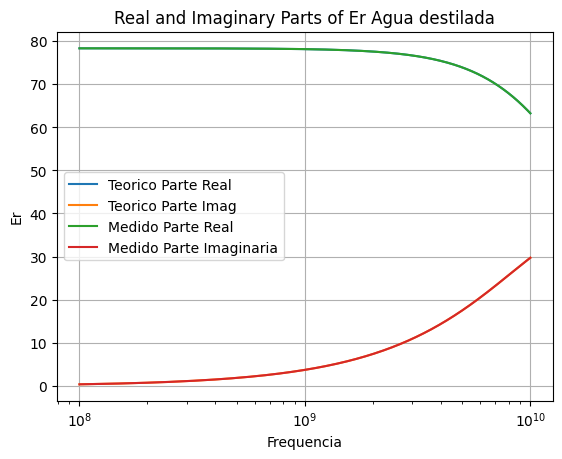

In [ ]:
# Plot real part
# Teorico
plt.plot(frecs, np.real(get_debye_model(frecs)), label= "Teorico Parte Real")
plt.plot(frecs, np.imag(get_debye_model(frecs)), label= "Teorico Parte Imag")
# Medido
plt.plot(frecs , np.real(er_agua), label='Medido Parte Real')
# Plot imaginary part
plt.plot(frecs ,np.imag(er_agua), label='Medido Parte Imaginaria')
# Set labels and title
plt.title('Real and Imaginary Parts of Er Agua destilada')
plt.xlabel('Frequencia')
plt.ylabel('Er')
plt.xscale('log')
# plt.xlim([108000000, 20000000000])
plt.legend()
# Display the plot
plt.grid(True)
plt.show()

Al dar similares los ploteos de las graficas imaginaria y real, se hizo un loop para comprobar diferencias, a partir de los 108MHz:

In [ ]:
for cuenta, value in enumerate(frecs):
  erteorico = get_debye_model(value)
  ermedido  = er_agua[cuenta]
  if not (erteorico==ermedido):
    print("frecuencia ",value , " diferencia: ", erteorico-ermedido )

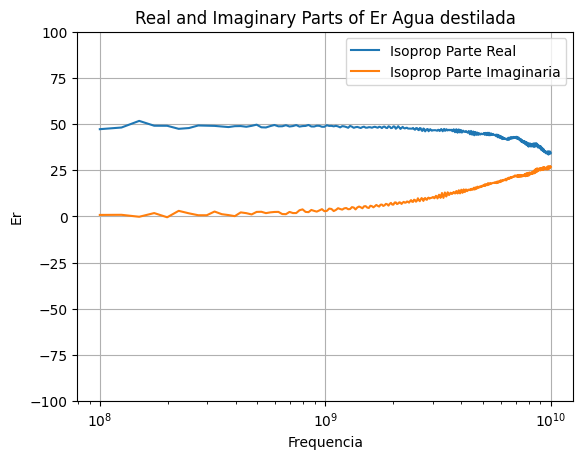

In [ ]:
# Plot real part
# Teorico
# plt.plot(frecs, np.real(get_er_pat_alc_isopropilico(frecs)), label= "Teorico Parte Real")
# plt.plot(frecs, np.imag(get_er_pat_alc_isopropilico(frecs)), label= "Teorico Parte Imag")
# Medido
plt.plot(frecs , np.real(er_acetona), label='Isoprop Parte Real')
# Plot imaginary part
plt.plot(frecs ,np.imag(er_acetona), label='Isoprop Parte Imaginaria')
# Set labels and title
plt.title('Real and Imaginary Parts of Er Agua destilada')
plt.xlabel('Frequencia')
plt.ylabel('Er')
plt.xscale('log')
# plt.xlim([108000000, 20000000000])
# plt.ylim([-100,100])
plt.legend()
# Display the plot
plt.grid(True)
plt.show()

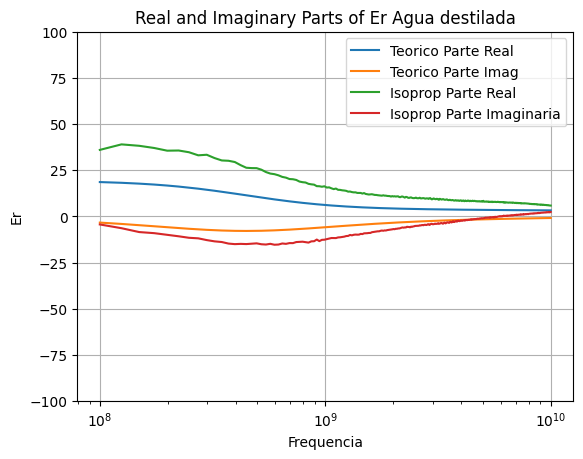

In [ ]:
# Plot real part
# Teorico
plt.plot(frecs, np.real(get_er_pat_alc_isopropilico(frecs)), label= "Teorico Parte Real")
plt.plot(frecs, np.imag(get_er_pat_alc_isopropilico(frecs)), label= "Teorico Parte Imag")
# Medido
plt.plot(frecs , np.real(er), label='Isoprop Parte Real')
# Plot imaginary part
plt.plot(frecs ,np.imag(er), label='Isoprop Parte Imaginaria')
# Set labels and title
plt.title('Real and Imaginary Parts of Er Agua destilada')
plt.xlabel('Frequencia')
plt.ylabel('Er')
plt.xscale('log')
# plt.xlim([108000000, 20000000000])
plt.ylim([-100,100])
plt.legend()
# Display the plot
plt.grid(True)
plt.show()